# 获取原始数据

In [31]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10 01:17:52
1,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10 01:23:50
2,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10 01:24:49
3,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10 01:24:49
4,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10 01:24:54
...,...,...,...,...
153322,1636505287,1151304179731807924804200863381341,0.000211,2021-11-10 00:48:07
153323,1636505306,1153213095406308275655367738380110,0.000212,2021-11-10 00:48:26
153324,1636505306,1153226560737155904671591020768514,0.000212,2021-11-10 00:48:26
153325,1636505306,1153227466349991390439811165863993,0.000212,2021-11-10 00:48:26


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:17:52'

# 指标计算

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos
datetime,,,,,,,,
2021-05-10 01:17:52,1620609472,1267554519342589161168659854845874,0.000256,False,False,False,False,True
2021-05-10 01:23:50,1620609830,1267498129839936824485169221023868,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496927736336268048970777338285,0.000256,False,False,False,False,True
2021-05-10 01:24:49,1620609889,1267496466129159558106023913391909,0.000256,False,False,False,False,True
2021-05-10 01:24:54,1620609894,1267269382521328460205280017540103,0.000256,False,False,False,False,True
...,...,...,...,...,...,...,...,...
2021-11-10 00:48:07,1636505287,1151304179731807924804200863381341,0.000211,True,True,False,False,False
2021-11-10 00:48:26,1636505306,1153213095406308275655367738380110,0.000212,True,True,False,False,False
2021-11-10 00:48:26,1636505306,1153226560737155904671591020768514,0.000212,True,True,False,False,False


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


# 建池撤池详细信息

In [5]:
import Strategy_usdceth_vol_v2
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_v2)
strategy = Strategy_usdceth_vol_v2.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  140631495516086534144
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00033005978975935465
$$$$$$$【Lower Price】: 0.00019849777291908478
######【L】:60666448444272064【USDC】:449725000000【ETH】:117247551451873394688
将要投入池子的数量 amount_t0: 449725000000 amount_t1: 117247551451873165312
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=60665339031571984, tick=[191040, 196140], range=[3035.1064, 5054.2070])
【Mint amount】: token0=449708.399096, token1=117.24755145187316
Wallet amount: token0=16.600904, token1=23.38394406421337
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: True
Price(0.00023814266965707472) out of range(0.00019849777291908478, 0.00033005978975935465)
【RealWorldT

******************************************【撤销池子】【原因:超边撤池】******************************************
Price(0.000277432219764514) out of range(0.00027786275245102074, 0.00046202695530153144)
【RealWorldTime】:2021-09-02 00:31:37,Timestamp: 1630513897, Blocknumber: 13140848
Decreased position： Position(L=0, tick=[194400, 199500], range=[2168.9936, 3611.9138])
【Decreased amount】: token0=1088041.69666, token1=3.192292366057026
Wallet amount: token0=1091277.683317, token1=43.08064536412536
撤池后经转换 Wallet amount: token0=1246121.902431, token1=2.1899148389064997
**********************【Price Over MA】【创建Long Vol池子】【第8次建池】***********************************
转换后钱包中余额 amount0:  560412172571.0 amount1:  192209139043566351168
price:  0.00027679293620883804
$$$$$$$【Upper Price】: 0.0003569221437470984
$$$$$$$【Lower Price】: 0.0002146527775799641
######【L】:78670523595172320【USDC】:560412172571【ETH】:158220682731461410816
将要投入池子的数量 amount_t0: 560412172571 amount_t1: 158220682731461148672
【RealWorldTime】:2021-0

# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x275cce27240>,
 2: <univ3api.simulation.PositionReport at 0x275cce27390>,
 3: <univ3api.simulation.PositionReport at 0x275cce16860>,
 4: <univ3api.simulation.PositionReport at 0x275cce16e48>,
 5: <univ3api.simulation.PositionReport at 0x275cce16080>,
 6: <univ3api.simulation.PositionReport at 0x275cce160f0>,
 7: <univ3api.simulation.PositionReport at 0x275cce16828>,
 8: <univ3api.simulation.PositionReport at 0x275cd59b8d0>,
 9: <univ3api.simulation.PositionReport at 0x275cd59bbe0>,
 10: <univ3api.simulation.PositionReport at 0x275cd59bd68>,
 11: <univ3api.simulation.PositionReport at 0x275cd59b390>}

In [7]:
positions[5].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-25 06:58:38,455205.323896,0.000000,0.000000,0.000000,216.949,0.000000e+00,0.000000e+00,0.000000e+00
1,2021-07-25 07:08:21,455203.011538,0.000000,0.000000,0.000000,216.95,5.337585e-07,5.337585e-07,5.337585e-07
2,2021-07-25 07:08:21,454918.923908,0.000000,0.000000,0.000000,217.082,6.558043e-05,6.611419e-05,6.611419e-05
3,2021-07-25 07:30:03,455217.118252,0.149097,0.149097,0.149097,216.944,0.000000e+00,6.611419e-05,6.611419e-05
4,2021-07-25 07:30:14,455926.749249,0.354815,0.503912,0.503912,216.616,0.000000e+00,6.611419e-05,6.611419e-05
5,2021-07-25 07:30:33,456793.341204,0.433295,0.937207,0.937207,216.216,0.000000e+00,6.611419e-05,6.611419e-05
6,2021-07-25 07:30:58,457107.803071,0.157230,1.094437,1.094437,216.071,0.000000e+00,6.611419e-05,6.611419e-05
7,2021-07-25 07:31:46,457427.748008,0.159972,1.254409,1.254409,215.924,0.000000e+00,6.611419e-05,6.611419e-05
8,2021-07-25 07:31:47,458166.802260,0.369527,1.623936,1.623936,215.583,0.000000e+00,6.611419e-05,6.611419e-05
9,2021-07-25 07:31:58,458585.427593,0.209312,1.833248,1.833248,215.39,0.000000e+00,6.611419e-05,6.611419e-05


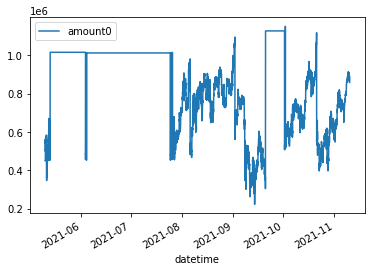

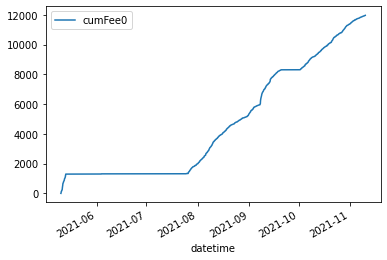

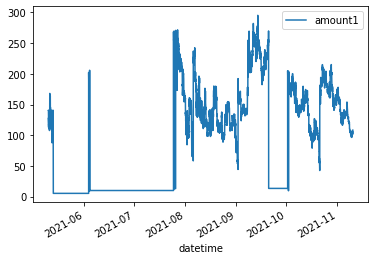

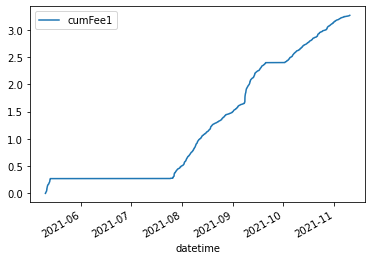

In [8]:
total_balance = report.total_balance(draw_plot=True, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:>

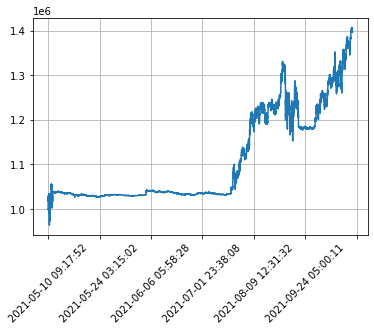

In [9]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [10]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,549425.062949
1620609830,549305.247193
1620609889,549301.311704
1620609894,548818.966510
1620610623,549850.784613
...,...
1636505114,519157.345520
1636505262,519366.958863
1636505287,519376.254695


In [11]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,449725.000000
1620609830,449893.864584
1620609889,449898.845178
1620609894,450579.025989
1620610623,449128.348311
...,...
1636505084,880773.721721
1636505114,879010.101413
1636505262,878747.380202


In [12]:
tb_Timing

2021-05-10 09:17:52    9.991501e+05
2021-05-10 09:23:50    9.991991e+05
2021-05-10 09:24:49    9.992002e+05
2021-05-10 09:24:54    9.993980e+05
2021-05-10 09:37:03    9.989791e+05
                           ...     
2021-11-10 08:45:14    1.398167e+06
2021-11-10 08:47:42    1.398114e+06
2021-11-10 08:48:07    1.398112e+06
2021-11-10 08:48:26    1.396384e+06
2021-11-10 08:48:53             NaN
Length: 118264, dtype: float64

# 计算绩效指标

In [13]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.031530e+06
2021-05-11    1.014772e+06
2021-05-12    1.039899e+06
2021-05-13    1.037414e+06
2021-05-14    1.039594e+06
                  ...     
2021-11-06    1.353541e+06
2021-11-07    1.381239e+06
2021-11-08    1.400191e+06
2021-11-09    1.404321e+06
2021-11-10    1.396384e+06
Freq: D, Length: 185, dtype: float64

In [14]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.031530e+06,NaN,NaN
2021-05-11,1.014772e+06,-0.016246,-0.016246
2021-05-12,1.039899e+06,0.024761,0.024761
2021-05-13,1.037414e+06,-0.002389,-0.002389
2021-05-14,1.039594e+06,0.002101,0.002101
...,...,...,...
2021-11-05,1.363994e+06,-0.002327,-0.002327
2021-11-06,1.353541e+06,-0.007663,-0.007663
2021-11-07,1.381239e+06,0.020463,0.020463
2021-11-08,1.400191e+06,0.013721,0.013721


<AxesSubplot:>

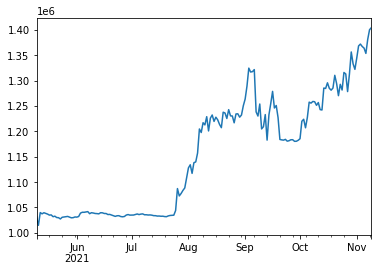

In [15]:
df_tb['close'].plot()

In [16]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_3000】

CumFee0 11975.355579 CumFee1 15412.933450180983
最大回撤 0.10889942555461862
最长回撤持续期 55 日 起始日期 2021-09-03 00:00:00 结束日期 2021-10-28 00:00:00
年化收益 0.8502776964801639
夏普比率 3.317736824067209
卡尔玛比率 7.807917187347386


<AxesSubplot:title={'center':'Total Balance'}>

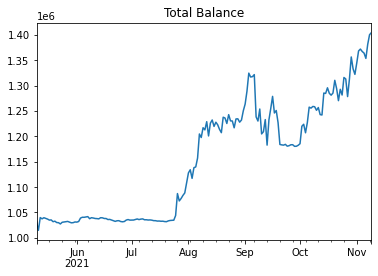

In [27]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('CumFee0',cumfee0,'CumFee1',cumfee1)

print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')